<a href="https://colab.research.google.com/github/twotablepush/OpenCV/blob/main/(%EC%8B%A4%EC%8A%B5)2017_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%ED%95%B4%ED%82%B9%EB%B0%A9%EC%96%B4%EB%8C%80%ED%9A%8C_ASM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2017 삼성전자 해킹방어대회 ASM 문제 환경 구축

## 문제의 동작을 확인하기
- START 버튼을 누르면 80초 타이머가 동작한다.
- Captcha와 같은 형태로 수식이 등장하며, 이를 반복적으로 풀어야 한다.
- 80초 안에 100개의 수식에 대하여 연속적으로 정답 처리를 받아야 한다.

## 문제 해경 방법
- 특정한 수식 사진을 OpenCV로 처리하여, 각 문자를 하나씩 분리
- 분리된 각 문자가 어떤 문자에 해당하는지 인식
- 인식된 수식을 계산하여 정답을 도출

## 데이터 수집하기
- 데이터의 개수가 적으므로 브라우저로 직접 수집한다.
- 가능한 12개의 문자 : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, +, -, *

# 데이터 분석하기
- 파란색 : RGB에서 B의 값이 항상 FF = 255
- 초록색 : RGB에서 G의 값이 항상 FF
- 빨간색 : RGB에서 R의 값이 항상 FF
- 파란색 & 초록색 : RGB에서 R 값이 항상 AA 이하 = 170
- 파란색 & 빨간색 : RGB에서 G 값이 항상 AA 이하
- 초록색 & 빨간색 : RGB에서 B 값이 항상 AA 이하
  



In [ ]:
# 데이터 정제하기
# 색상별로 이미지 추출 (utils.py)
BLUE = 0
GREEN = 1
RED = 2


# 특정한 색상의 모든 단어가 포함된 이미지를 추출한다.
def get_chars(image, color):  # 만약 color이 Blue 라면
  other_1 = (color + 1) % 3   # other_1 = Green
  other_2 = (color + 2) % 3   # other_2 = Red

  c = image[:, :, other_1] == 255
  image[c] = [0, 0, 0]  # 검정색으로 변환
  c = image[:, :, other_2] == 255
  image[c] = [0, 0, 0]
  c = image[:, :, color] < 130  # 선택한 색상(Blue)의 색상이 170 = AA보다 작다면 즉 Green과 Red가 섞인 부분
  image[c] = [0, 0, 0]
  c = image[:, :, color] != 0 # 남은 Blue
  image[c] = [255, 255, 255]  # 하얀색으로 변환

  return image

In [ ]:
# 테스트 코드 (test.py)

import cv2
import utils

image = cv2.imread("stage3.png", cv2.IMREAD_COLOR)
blue = utils.get_chars(image.copy(), utils.BLUE)
green = utils.get_chars(image.copy(), utils.GREEN)
red = utils.get_chars(image.copy(), utils.RED)
cv2.imshow("Image Gray", blue)
cv2.waitKey(0)
cv2.imshow("Image Gray", green)
cv2.waitKey(0)
cv2.imshow("Image Gray", red)
cv2.waitKey(0)

In [ ]:
# 트레이닝 데이터 만들기
# 전체 이미지에서 왼쪽부터 단어별로 추출 (utils.py)
# 전체 이미지에서 왼쪽부터 단어별로 이미지를 추출
import cv2

def extract_chars(image):
    chars = []
    colors = [BLUE, GREEN, RED]
    for color in colors:
        image_from_one_color = get_chars(image.copy(), color)
        image_gray = cv2.cvtColor(image_from_one_color, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(image_gray, 127, 255, 0)
        # RETR_EXTERNAL 옵션으로 숫자의 외각을 기준으로 분리
        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        for contour in contours:
            # 추출된 이미지 크기가 50 이상인 경우만 실제 문자 데이터인 것으로 파악
            area = cv2.contourArea(contour)
            if area > 50:
                x, y, width, height = cv2.boundingRect(contour)
                roi = image_gray[y : y + height, x : x + width]
                chars.append((x, roi))
                # 전체 문자들을 x 좌표 기준으로 정렬
                chars = sorted(chars, key=lambda char: char[0])
    return chars

In [ ]:
# 트레이닝 데이터 만들기
# 이미지를 (20X20) 크기로 통일 (utils.py)

import numpy as np

#특정한 이미지를 (20X20) 크기로 Scaling
def resize20(image):
    resized = cv2.resize(image, (20, 20))
    return resized.reshape(-1, 400).astype(np.float32)

In [ ]:
# 데이터 만들기 (make_train_data.py)

import os
import cv2
import utils

# training_data 폴더 생성 및 그 내부에 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10(+), 11(-), 12(*) 폴더 생성
image = cv2.imread("stage6.png")
chars = utils.extract_chars(image)

for char in chars:
    cv2.imshow('Image', char[1])
    input = cv2.waitKey(0)
    resized = cv2.resize(char[1], (20, 20))

    if 48 <= input <= 57:
        name = str(input - 48)
        file_count = len(next(os.walk('./training_data/' + name + '/'))[2])
        cv2.imwrite('./training_data/' + str(input - 48) + '/' +
                    str(file_count + 1) + '.png', resized)
    elif input in (ord('a'), ord('b'), ord('c')):
        name = str(input - ord('a') + 10)
        file_count = len(next(os.walk('./training_data/' + name + '/'))[2])
        cv2.imwrite('./training_data/' + name + '/' +
                    str(file_count + 1) + '.png', resized)

In [ ]:
# KNN 모델 학습하기 (knn_trainer.py)

import os
import cv2
import numpy as np

file_names = list(range(0, 13))
train = []
train_labels = []

for file_name in file_names:
  path = './training_data/' + str(file_name) + '/'
  file_count = len(next(os.walk(path))[2])
  for i in range(1, file_count + 1):
    img = cv2.imread(path + str(i) + '.png')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train.append(gray)
    train_labels.append(file_name)

x = np.array(train)
train = x[:, :].reshape(-1, 400).astype(np.float32)
train_labels = np.array(train_labels)[:, np.newaxis]

print(train.shape)
print(train_labels.shape)

np.savez("trained.npz", train = train, train_labels = train_labels)

In [ ]:
# 학습된 모델로 테스트 하기 : 학습된 KNN 모델 불러오기 (run.py)

import numpy as np
import cv2
import utils

FILE_NAME = 'trained.npz'

# 각 글자의 (1 x 400) 데이터와 정답 (0 ~ 9, +, *)
with np.load(FILE_NAME) as data:
  train = data['train']
  train_labels = data['train_labels']

knn = cv2.ml.KNearest_create()
knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)

def check(test, train, train_labels):
  # 가장 가까운 K개의 글자를 찾아 어떤 숫자에 해당하는지 찾는다.
  ret, result, neighbours, dist = knn.findNearest(test, k = 1)
  return result

In [ ]:
# 테스트 결과 확인하기 (run.py)

def get_result(file_name):
  image = cv2.imread(file_name)
  chars = utils.extract_chars(image)
  result_string = ""
  for char in chars:
    matched = check(utils.resize20(char[1]), train, train_labels)
    if matched < 10:
      result_string += str(int(matched))
      continue
    if matched == 10:
      matched = '+'
    elif matched == 11:
      matched = '-'
    elif matched == 12:
      matched = '*'
    result_string += matched
  return result_string

print(get_result("stage7.png"))

In [ ]:
# 해킹 자동화
# 수식 정제 (utils.py)

import re

def remove_first_0(string):
  temp = []
  for i in string:
    if i == '+' or i == '-' or i == '*':
      temp.append(i)
  split = re.split('\*|\+|-', string)
  i = 0
  temp_count = 0
  result = ""
  for a in split:
    a = a.lstrip('0')
    if a == '':
      a = '0'
    result += a
    if i < len(split) - 1:
      result += temp[temp_count]
      temp_count = temp_count + 1
    i = i + 1
  return result

In [ ]:
# 해킹 자동화
# 구현 완료 (run.py)

import requests
import shutil
import time

host = "http://127.0.0.1:10000"
url = '/start'

# target_images 라는 폴더 생성
with requests.Session() as s:
  answer = ''
  for i in range(0, 100):
    start_time = time.time()
    params = {'ans': answer}

    # 정답을 파라미터에 달아서 전송하여, 이미지 경로를 받아온다.
    response = s.post(host + url, params)
    print('Server Return: ' + response.text)
    if i == 0:
      returned = response.text
      image_url = host + returned
      url = '/check'
    else:
      returned = response.json()
      image_url = host + returned['url']
    print('Problem ' + str(i) + ': ' + image_url)

    # 특정한 폴더에 이미지 파일을 다운로드
    response = s.get(image_url, stream=True)
    target_image = './target_images/' + str(i) + '.png'
    with open(target_image, 'wb') as out_file:
      shutil.copyfileobj(response.raw, out_file)
    del response

    # 다운로드 받은 이미지 파일을 분석하여 답을 도출
    answer_string = get_result(target_image)
    print('String: ' + answer_string)
    answer_string = utils.remove_first_0(answer_string)
    answer = str(eval(answer_string))
    print('Answer: ' + answer)
    print("--- %s seconds ---" % (time.time() - start_time))

# 실행결과 캡처
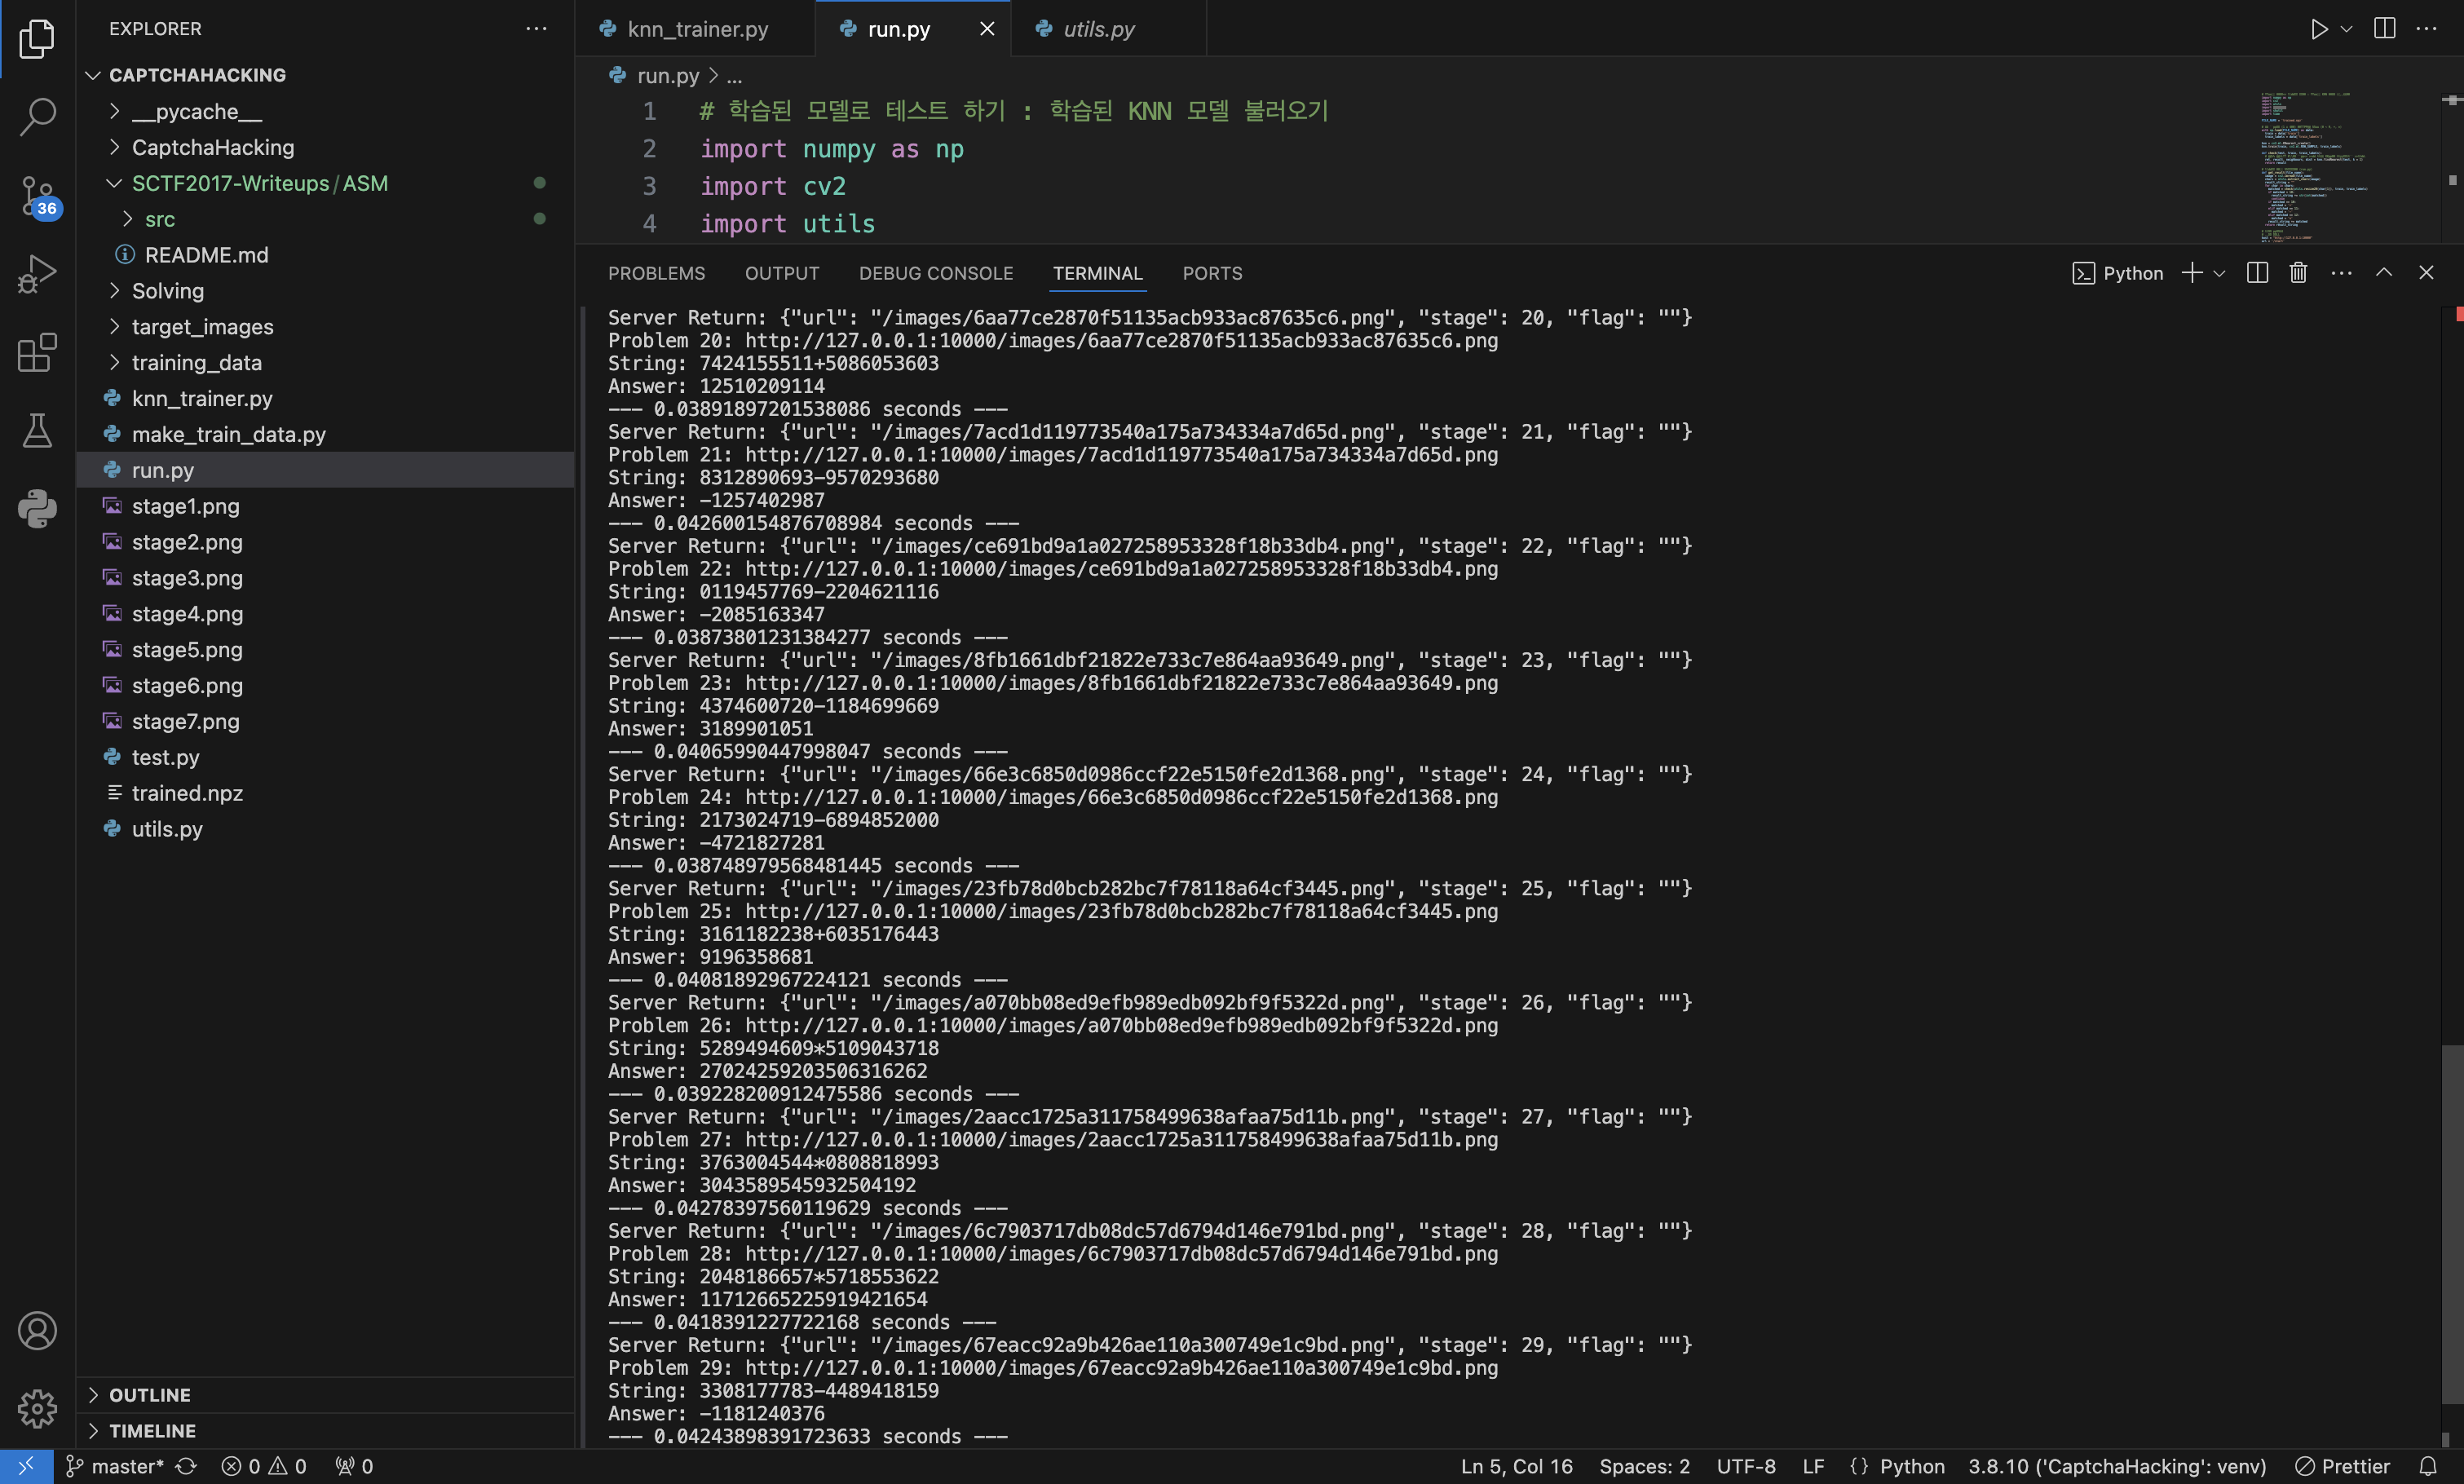